In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Hyperparameters
latent_dim = 100
batch_size = 256
epochs = 50
lr = 0.0002  # Slightly increased learning rate
beta1 = 0.5
beta2 = 0.999  # Added beta2 for Adam optimizer
image_size = 28 * 28

In [3]:
# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root="./data_gitignore", train=True, transform=transform, download=True
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 33.3kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 172kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.10MB/s]


In [4]:
# Generator class with improved architecture
class Generator(nn.Module):
    def __init__(self, latent_dim=100, output_dim=784):
        super(Generator, self).__init__()

        # Improved architecture with batch normalization and LeakyReLU
        self.model = nn.Sequential(
            # First layer
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Second layer
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Third layer
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # Final layer
            nn.Linear(1024, output_dim),
            nn.Tanh(),  # Tanh to output values in [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [5]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, input_dim=784):
        super(Discriminator, self).__init__()

        # Using LeakyReLU instead of ReLU for better gradients
        self.model = nn.Sequential(
            # First layer
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            # Second layer
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            # Third layer
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [6]:
# Initialize models
generator = Generator(latent_dim=latent_dim, output_dim=image_size).to(device)
discriminator = Discriminator(input_dim=image_size).to(device)

# Print model summaries
print("Generator architecture:")
print(generator)
print("\nDiscriminator architecture:")
print(discriminator)

# Loss function
criterion = nn.BCELoss()

# Optimizers with improved parameters
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


# Utility function to show generated images
def show_generated_images(generator, epoch, fixed_noise, save=True):
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()

    # Reshape to 28x28 images
    fake_images = fake_images.view(-1, 28, 28).numpy()

    # Plot some examples
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(fake_images[i], cmap="gray")
        plt.axis("off")

    if save:
        plt.savefig(f"gan_images_epoch_{epoch}.png")
        plt.close()
    else:
        plt.show()

    generator.train()  # Set back to training mode

Generator architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(i

Starting training...
[Epoch 0/50] [Batch 0/235] [D loss: 1.3767] [G loss: 0.6894]
[Epoch 0/50] [Batch 100/235] [D loss: 1.3356] [G loss: 0.8762]
[Epoch 0/50] [Batch 200/235] [D loss: 1.0498] [G loss: 1.4171]
[Epoch 1/50] [Batch 0/235] [D loss: 1.5139] [G loss: 1.1867]
[Epoch 1/50] [Batch 100/235] [D loss: 1.0825] [G loss: 0.9484]
[Epoch 1/50] [Batch 200/235] [D loss: 1.0359] [G loss: 0.9894]
[Epoch 2/50] [Batch 0/235] [D loss: 1.1161] [G loss: 1.6158]
[Epoch 2/50] [Batch 100/235] [D loss: 1.3813] [G loss: 1.2203]
[Epoch 2/50] [Batch 200/235] [D loss: 1.0896] [G loss: 0.9995]
[Epoch 3/50] [Batch 0/235] [D loss: 1.0448] [G loss: 1.0189]
[Epoch 3/50] [Batch 100/235] [D loss: 1.2692] [G loss: 0.5722]
[Epoch 3/50] [Batch 200/235] [D loss: 1.0834] [G loss: 1.0391]
[Epoch 4/50] [Batch 0/235] [D loss: 1.2627] [G loss: 1.9213]
[Epoch 4/50] [Batch 100/235] [D loss: 1.0339] [G loss: 1.1421]
[Epoch 4/50] [Batch 200/235] [D loss: 1.0037] [G loss: 1.3176]
[Epoch 5/50] [Batch 0/235] [D loss: 1.1657] 

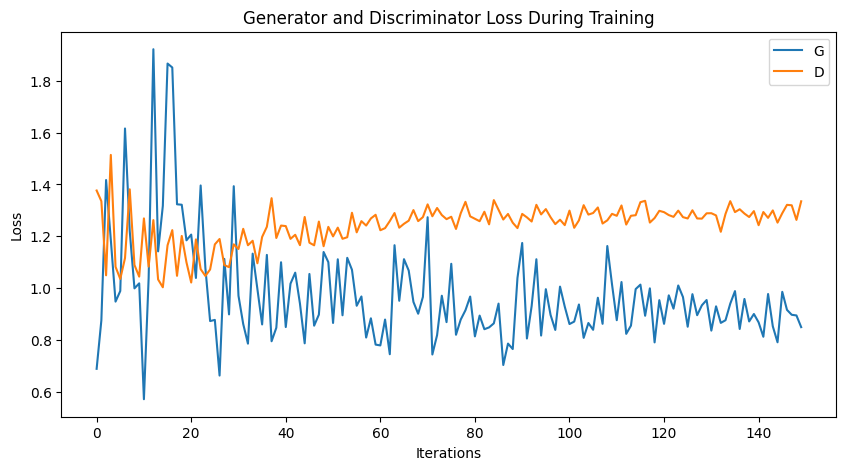

In [7]:
# Training loop
fixed_noise = torch.randn(10, latent_dim, device=device)  # For visualization
real_label = 1
fake_label = 0

# Lists to keep track of loss
G_losses = []
D_losses = []

print("Starting training...")

for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        # Configure input
        real_images = real_images.view(-1, image_size).to(device)
        batch_size = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Create labels
        real_labels = torch.full(
            (batch_size, 1), real_label, dtype=torch.float, device=device
        )
        fake_labels = torch.full(
            (batch_size, 1), fake_label, dtype=torch.float, device=device
        )

        # Train with real images
        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        outputs = discriminator(
            fake_images.detach()
        )  # Detach to avoid training G on these labels
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()

        # Combined loss and optimizer step
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        # We want the discriminator to label the generated samples as valid
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(
            outputs, real_labels
        )  # We want generator to fool discriminator
        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        if batch_idx % 100 == 0:
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())
            print(
                f"[Epoch {epoch}/{epochs}] [Batch {batch_idx}/{len(train_loader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    # Generate images after each epoch
    if epoch % 5 == 0 or epoch == epochs - 1:
        show_generated_images(generator, epoch, fixed_noise, save=True)

# Save the generator model
torch.save(generator.state_dict(), "g.pth")
print("Training complete! Generator model saved as 'generator_mnist.pth'")

# Plot the training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("gan_loss_plot.png")
plt.show()

Generating final sample images...


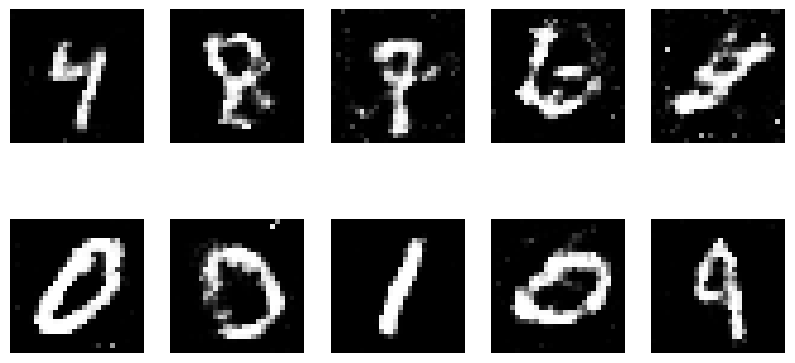

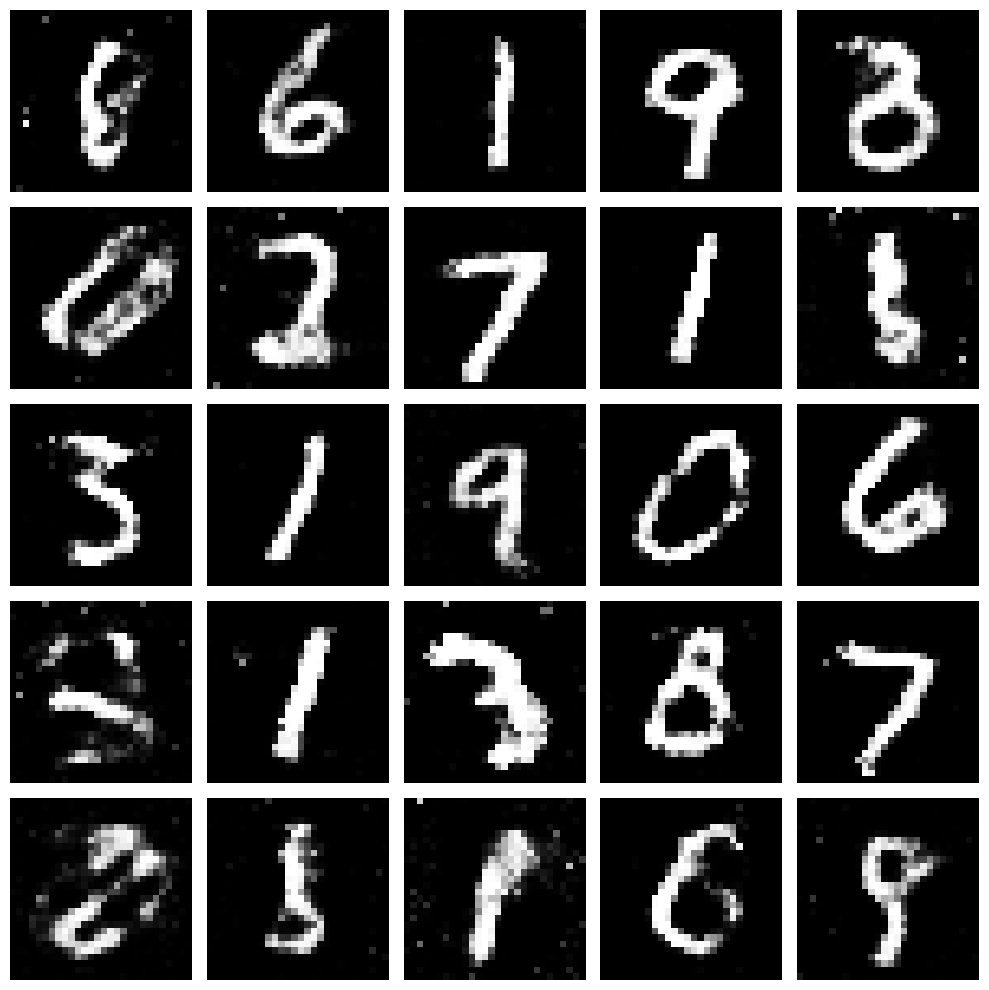

In [8]:
# Show some final generated images
print("Generating final sample images...")
noise = torch.randn(16, latent_dim, device=device)
show_generated_images(generator, epochs, noise, save=False)


# Function to generate and display multiple images
def generate_and_display(num_images=25):
    noise = torch.randn(num_images, latent_dim, device=device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(noise).detach().cpu()

    # Reshape and plot
    fake_images = fake_images.view(-1, 28, 28).numpy()

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(fake_images[i], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Generate and display a grid of images
generate_and_display(25)